In [1]:
import copy
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.

# Load data

In [2]:
# Load the train/val/test dataset

df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy()

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy()

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

print(y_test.shape)

(800, 7)
(800,)
(800, 7)
(800,)
(800, 7)
(800,)


# Model Implementation

$$gini = 1 - \sum_{i=1}^{C}(p_i)^2$$

In [4]:
import math 

def get_probabilities(sequence):
    unique_y = np.unique(sequence)
    count_y = {}
    for u in sequence:
        if u in count_y:
            count_y[u] += 1
        else:
            count_y[u] = 1

    N = len(sequence)
    for k,v in count_y.items():
        count_y[k] = v / N

    probabilities = np.array(list(count_y.values()))
    
    if not math.isclose(np.sum(probabilities),1):
        raise AssertionError(np.sum(probabilities))

    return probabilities


seq = np.array([0,0,0,0,1,1,1,1,1,1])
assert np.all(get_probabilities(seq) == np.array([0.4, 0.6]))

In [5]:
def entropy(sequence):
    probabilities = get_probabilities(sequence)
    
    entropy = np.sum(-probabilities * np.log2(probabilities+1e-9))

    return entropy

assert not np.isclose(entropy(seq), 0.97)

In [6]:
def gini(sequence):
    probabilities = get_probabilities(sequence)
    
    return 1 - (probabilities**2).sum()

assert gini(seq) == 0.48

In [7]:
def cart_info_gain(feature_x, value, y, func=gini):
    left_mask = feature_x <= value
    right_mask= feature_x >  value

    left_y = y[left_mask]
    right_y= y[right_mask]

    if left_y.size == 0 or right_y.size == 0:
        return 1e+9
    
    left = func(left_y)
    right= func(right_y)

    p = left_y.size / y.size

    # return total - p*left - (1-p)*right
    return p*left + (1-p)*right 

feature_x = np.array(
    [1,2,1,2, 3,4,3,3,3])
y = np.array(
    [0,1,0,1, 0,0,0,1,0])
value = 2

# feature_x = np.array(
#     [1,2,1,2, 3,4,3,3,3])
# y = np.array(
#     [0,1,0,1, 0,0,0,1,0])
# value = 4

value_gini = cart_info_gain(feature_x, value, y, gini) 
assert not np.isclose(value_gini, 0.39)
# value_gini

In [8]:
def get_best_split_params(X,y,func=gini):

    best_info_gain = 1e+9
    best_feature_idx = None
    best_split_value = None

    for feature_idx in range(X.shape[1]):
        feature_x = X[:, feature_idx] 
        
        unique_x = np.unique(feature_x)
        sorted_unique_x = sorted(unique_x)
        mean_x = []
        for i in range(len(sorted_unique_x)-1):
            mean_x += [(unique_x[i+1] + unique_x[i]) / 2]

        for value in mean_x:

            gain_info = cart_info_gain(feature_x, value, y, func)
            # print(value, gain_info), #'\t', total_value - info)

            if gain_info < best_info_gain:
                best_info_gain = gain_info
                best_feature_idx = feature_idx
                best_split_value = value
    return best_feature_idx, best_split_value, best_info_gain

X = np.array([
    [1],
    [2],
    [3],
    [4],
    [5],
    [6]
    ])
y = np.array([1,1,1,1,0,0])


best_idx, best_value, best_gain = get_best_split_params(X, y)
# print(best_idx, best_value, best_gain)
assert best_value == 4.5
assert best_gain == 0



In [9]:
def split_data(X,y,feature_idx,value):
    feature = X[:,feature_idx] 

    mask_l = feature <= value
    mask_r = feature >  value

    X_l = X[mask_l]
    X_r = X[mask_r]

    y_l = y[mask_l]
    y_r = y[mask_r]

    return X_l, X_r, y_l, y_r

X_l, X_r, y_l, y_r = split_data(X, y, best_idx, best_value)
# X_l.shape, X_r.shape, y_l.shape, y_r.shape
# X_l, X_r, y_l, y_r

In [10]:
# TreeNode to build a tree
class TreeNode():
    def __init__(self, parent_node):
        self.parent = parent_node

        self.child_left = None
        self.child_right = None

        self.split_feature_idx = None
        self.split_value = None

        self.prediction = None
        self.info_gain = None

In [11]:
def build_tree(X,y,node,criterion=gini,max_depth=3,depth=0):
    node = TreeNode(node)
    
    # if only one class or X is the same values
    y_unique = np.unique(y.astype(np.int32)) 
    # This must be 1, if features are the same
    x_unique = np.sum([np.unique(X[:,i]).size for i in range(X.shape[1])]) / X.shape[1] 
    # print(y_unique, y_unique.size, nfeature-1)
    if y_unique.size == 1 or x_unique == 1:
    # if y_unique.size == 1:
        node.prediction = np.argmax(np.bincount(y.astype(np.int32)))
        return node

    if depth >= max_depth:
        node.prediction = np.argmax(np.bincount(y.astype(np.int32)))
        return node

    best_idx, best_value, best_gain = get_best_split_params(X, y, criterion)
    node.split_feature_idx = best_idx
    node.split_value = best_value
    node.info_gain = best_gain

    # if np.isclose(best_value, 0.9775) and  np.isclose(best_gain, 0.3333333333333333):
    #     print('will brake')

    X_l, X_r, y_l, y_r = split_data(X, y, best_idx, best_value)
    
    # print(best_gain, best_idx, best_value)
    # print(X_l.shape, X_r.shape, y_l.shape, y_r.shape)

    node.child_left = build_tree(X_l, y_l, node, criterion, max_depth, depth+1)
    node.child_right = build_tree(X_r, y_r, node, criterion, max_depth, depth+1)
    
    return node
    
X = np.array([
    [1],
    [2],
    [3],
    [4],
    [5],
    [6],
])
y = np.array([0,1,2,0,1,2])

root = build_tree(X, y, None, gini, 3)


In [12]:
def rec_prediction(sample, node):
    if node.child_left is None or node.child_right is None:
        return node.prediction
    
    if sample[node.split_feature_idx] <= node.split_value:
        # print('go left')
        node = node.child_left
    else:
        # print('go right')
        node = node.child_right

    prediction = rec_prediction(sample, node)

    return prediction

# for i in range(6):
#     x = X[i]
#     _y = int(y[i])
#     y_hat = rec_prediction(x, root)
#     print(_y, y_hat)
    
# root = build_tree(X_train, y_train, None, gini, 3, 0)
    


In [13]:
'''
Importance
sum of the improvments(information_gains) in all nodes where feature used as splitter
'''

def feature_importance(collector, node):
    # print(collector)
    if node.child_left is None or node.child_right is None:
        return
    
    if node.split_feature_idx in collector:
        collector[node.split_feature_idx] += 1 #node.info_gain
    else:
        collector[node.split_feature_idx] = 1 #node.info_gain

    feature_importance(collector, node.child_left)
    feature_importance(collector, node.child_right)

    return collector

# node = root
# node.split_feature_idx, node.info_gain

# collector = {}
# feature_importance(collector, root)
# print('-'*24)
# print(collector)


In [14]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None):
        
        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        
        if max_depth is None:
            self.max_depth = 1e9
        else:
            self.max_depth = max_depth

        self.importance = {}

    def fit(self, X, y, sample_weight=None):
        self.root = build_tree(X, y, None, self.criterion, self.max_depth, 0)

    def predict(self, X):
        n_samples, n_features = X.shape
        y_pred = []
        for n in range(n_samples):
            predicted_class = rec_prediction(X[n], self.root)
            y_pred += [predicted_class]
        return np.array(y_pred)
            

    def countImportance(self):
        collector = {}
        feature_importance(collector, self.root)
        self.importance = collector 

In [15]:
class RandomForest():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth

        self.tree_features = []
        
    def fit(self, X, y):
        n_samples, n_features = X.shape

        self.estimatiors = []

        for _ in range(self.n_estimators):

            if self.max_features:
                n_features = round(self.max_features)
                sample_features = np.random.choice(range(X.shape[1]), n_features, replace=False)
            else:
                rand_feature = np.random.randint(2, n_features)
                sample_features = np.random.choice(range(X.shape[1]), rand_feature, replace=False)

            # Different samples
            
        
            sample_idxs = np.random.choice(range(X.shape[0]), n_samples)#, replace=False)
            
            # save feature number
            self.tree_features += [sample_features]

            # genearte new data
            sampled_X = X[sample_idxs]
            sampled_X = sampled_X[:, sample_features]
            sampled_y = y[sample_idxs]

            # Train trees
            dtree = DecisionTree(self.criterion, self.max_depth, self.max_features)
            dtree.fit(sampled_X, sampled_y)

            self.estimatiors += [dtree]

    def predict(self, X):
        # majority vote

        n_predictions = []

        for n in range(self.n_estimators):

            feature_idx = self.tree_features[n]

            y_pred = self.estimatiors[n].predict(X[:,feature_idx])
            # print(y_pred)
            n_predictions += [y_pred]

        # print(n_predictions)

        preds = np.concatenate([x.reshape(1,-1) for x in n_predictions], axis=0)
        
        votes = []

        for p in preds.T:
            # print(p, np.argmax(np.bincount(p)))
            vote = np.argmax(np.bincount(p))
            votes += [vote]

        return np.array(votes)

# For Q7-2, validation accuracy should be higher than or equal to 0.86

# np.random.seed(0)

# rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
# rf_maxfeature_none.fit(X_train, y_train)

# print("Q7-1 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

# Questions for Decision Tree

In [16]:
# For Q1
ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])

print(f"{ex1}: entropy = {entropy(ex1)}\n{ex2}: entropy = {entropy(ex2)}\n{ex3}: entropy = {entropy(ex3)}\n")
print(f"{ex1}: gini index = {gini(ex1)}\n{ex2}: gini index = {gini(ex2)}\n{ex3}: gini index = {gini(ex3)}\n")

['+' '+' '+' '+' '+' '-']: entropy = 0.6500224187629642
['+' '+' '+' '-' '-' '-']: entropy = 0.99999999711461
['+' '-' '-' '-' '-' '-']: entropy = 0.6500224187629642

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [17]:
# For Q2-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0) # You may adjust the seed number in all the cells

dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_depth3.fit(X_train, y_train, sample_weight=None)

acc = accuracy_score(y_val, dt_depth3.predict(X_val))

print("Q2-1 max_depth=3: ", acc)

Q2-1 max_depth=3:  0.73125


In [18]:
""" Do Not Modify Below """

from sklearn.tree import DecisionTreeClassifier as SK_DecisionTreeClassifier

sk_dt = SK_DecisionTreeClassifier(criterion='gini', max_depth=3)
sk_dt.fit(X_train, y_train)
sk_acc = accuracy_score(y_val, sk_dt.predict(X_val))

assert round(acc, 3) == round(sk_acc, 3), "Because the Decision Tree without any trick has a fixed answer, your accuracy should be the same as sklearn, otherwise your implementation might have some problems"

In [19]:
# For Q2-2, validation accuracy should be higher than or equal to 0.85

np.random.seed(0)

dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dt_depth10.fit(X_train, y_train, sample_weight=None)

print("Q2-2 max_depth=10: ", accuracy_score(y_val,  dt_depth10.predict(X_val)))

Q2-2 max_depth=10:  0.86125


In [20]:
# For Q3-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0)

dt_gini = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_gini.fit(X_train, y_train, sample_weight=None)

print("Q3-1 criterion='gini': ", accuracy_score(y_val, dt_gini.predict(X_val)))


Q3-1 criterion='gini':  0.73125


In [21]:
# For Q3-2, validation accuracy should be higher than or equal to 0.77

np.random.seed(0)

dt_entropy = DecisionTree(criterion='entropy', max_features=None, max_depth=3)
dt_entropy.fit(X_train, y_train, sample_weight=None)

print("Q3-2 criterion='entropy': ", accuracy_score(y_val, dt_entropy.predict(X_val)))

Q3-2 criterion='entropy':  0.77


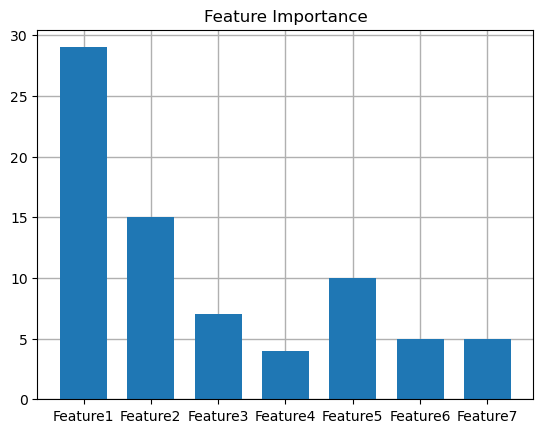

In [22]:
# For Q4
import matplotlib.pyplot as plt
np.random.seed(0)
dtree = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dtree.fit(X_train, y_train, sample_weight=None)

# Prepare importance for plotting
dtree.countImportance()

X_importance = []
for i in range(X_train.shape[1]):
    cond = i in dtree.importance.keys()
    # print(i, cond, X.shape[1])
    if cond:
        X_importance += [dtree.importance[i]]
    else:
        X_importance += [0]

# Use simply counting to get the feature importance: dt_depth10.importance
labelList=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']

plt.grid('major', linewidth=1, zorder=0)
plt.bar(np.arange(len(X_importance)), X_importance, 0.7, zorder=2)


plt.xticks(np.arange(len(labelList)), labelList)
plt.title('Feature Importance')
plt.show()

# Questions for Random Rorest

In [23]:
# For Q5-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)

rf_estimators10 = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)

print("Q5-1 n_estimators=10: ", accuracy_score(y_val, rf_estimators10.predict(X_val)))

Q5-1 n_estimators=10:  0.8775


In [24]:
# For Q5-2, validation accuracy should be higher than or equal to 0.89

np.random.seed(0)

rf_estimators50 = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators50.fit(X_train, y_train)

print("Q5-1 n_estimators=50: ", accuracy_score(y_val, rf_estimators50.predict(X_val)))

Q5-1 n_estimators=50:  0.89625


In [25]:
# For Q6-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)
    
rf_maxfeature_sqrt = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)

print("Q6-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

Q6-1 max_features='sqrt':  0.8775


In [26]:
# For Q6-2, validation accuracy should be higher than or equal to 0.86

np.random.seed(0)

rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_none.fit(X_train, y_train)

print("Q6-2 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

Q6-2 max_features='All':  0.87


# Train your own model

In [27]:
np.random.seed(0)

model = RandomForest(n_estimators=50, max_features=4, boostrap=True, criterion='gini', max_depth=15)
model.fit(X_train, y_train)

print("Validation score: ", accuracy_score(y_val, model.predict(X_val)))

Validation score:  0.90625


In [28]:
test_pred = model.predict(X_test)
test_pred

array([6, 5, 3, 3, 3, 2, 6, 6, 6, 3, 0, 3, 3, 2, 4, 3, 0, 3, 4, 3, 2, 3,
       4, 3, 3, 6, 5, 0, 3, 5, 1, 6, 5, 6, 3, 2, 3, 0, 0, 3, 5, 3, 0, 3,
       3, 6, 4, 4, 3, 2, 5, 2, 3, 5, 6, 4, 5, 6, 5, 3, 3, 5, 3, 2, 4, 5,
       0, 0, 6, 1, 6, 2, 5, 3, 3, 3, 2, 0, 0, 3, 5, 6, 1, 6, 5, 0, 6, 6,
       6, 6, 0, 4, 3, 6, 4, 0, 4, 1, 6, 6, 5, 5, 2, 3, 2, 6, 6, 3, 6, 3,
       1, 4, 5, 5, 3, 3, 3, 6, 5, 5, 1, 3, 1, 6, 2, 3, 6, 4, 3, 5, 2, 3,
       6, 5, 4, 5, 3, 6, 3, 6, 0, 5, 6, 4, 0, 5, 6, 4, 5, 1, 6, 5, 3, 2,
       6, 6, 2, 2, 6, 5, 0, 6, 0, 5, 6, 5, 6, 6, 3, 5, 6, 3, 6, 3, 5, 5,
       6, 2, 6, 4, 0, 6, 0, 4, 4, 5, 6, 0, 5, 3, 4, 6, 3, 4, 3, 4, 3, 5,
       0, 5, 4, 3, 4, 4, 3, 6, 0, 5, 5, 5, 6, 5, 4, 0, 0, 2, 5, 6, 4, 1,
       0, 3, 6, 4, 6, 2, 5, 5, 4, 5, 2, 2, 5, 3, 3, 4, 6, 2, 5, 0, 3, 3,
       4, 3, 4, 3, 3, 4, 2, 3, 5, 4, 0, 0, 3, 0, 1, 1, 6, 3, 6, 1, 6, 3,
       3, 3, 5, 5, 4, 2, 3, 3, 3, 6, 3, 6, 5, 6, 3, 4, 6, 3, 2, 1, 2, 3,
       3, 6, 3, 6, 3, 3, 5, 5, 3, 4, 3, 2, 6, 6, 0,

In [29]:
# output csv
df_test = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("prediction.csv")

In [30]:
# Q Part 2.1
np.random.seed(0) # You may adjust the seed number in all the cells

dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=None)
dt_depth3.fit(X_train, y_train, sample_weight=None)

acc = accuracy_score(y_train, dt_depth3.predict(X_train))

print("Train acc: ", acc)

Train acc:  1.0


In [31]:
# Q PART 2.3
import numpy as np
C1 = np.zeros(400)
C2 = np.zeros(400) +1

# Tree model A
Aleaf_11 = (C1[:200], C2)
Aleaf_12 = (C1[:200], C1[:0])

# Tree model B
Bleaf_11 = (C1[:300], C2[:100])
Bleaf_12 = (C1[:100], C2[:300])

Aleaf_11_c = np.concatenate(Aleaf_11)
Aleaf_12_c = np.concatenate(Aleaf_12)

Aleaf_11_class = np.argmax(np.bincount(Aleaf_11_c.astype(int)))
Aleaf_12_class = np.argmax(np.bincount(Aleaf_12_c.astype(int)))
print('A', Aleaf_11_class, Aleaf_12_class)

Bleaf_11_c = np.concatenate(Bleaf_11)
Bleaf_12_c = np.concatenate(Bleaf_12)

Bleaf_11_class = np.argmax(np.bincount(Bleaf_11_c.astype(int)))
Bleaf_12_class = np.argmax(np.bincount(Bleaf_12_c.astype(int)))
print('B', Bleaf_11_class, Bleaf_12_class)
################################################################
print('A gini:', gini(Aleaf_11_c), gini(Aleaf_12_c))
print('B gini:', gini(Bleaf_11_c), gini(Bleaf_12_c))

print('A entropy:', entropy(Aleaf_11_c), entropy(Aleaf_12_c))
print('B entropy:', entropy(Bleaf_11_c), entropy(Bleaf_12_c))



A 1 0
B 0 1
A gini: 0.4444444444444444 0.0
B gini: 0.375 0.375
A entropy: 0.9182958311690995 -1.4426951595367387e-09
B entropy: 0.8112781215737428 0.8112781215737428
